## Differential Expression Analysis - RhithroLoxo

First, make sure you're actually running this from a compute node, not the login. Logins are pn001 and 002. All others are higher.

In [1]:
Sys.info()

sysname                               release 
                              "Linux"           "3.10.0-693.2.2.el7.x86_64" 
                              version                              nodename 
"#1 SMP Tue Sep 12 22:26:13 UTC 2017"                               "pn039" 
                              machine                                 login 
                             "x86_64"                             "unknown" 
                                 user                        effective_user 
                            "ztobias"                             "ztobias"

Now load in the packages.

In [4]:
require(DESeq2)
require(ggplot2)
require(apeglm)

Now import the count data, rounding decimals to integers.

In [69]:
path_to_main <- "/vortexfs1/scratch/ztobias/RhithroLoxo_DE/" #change accordingly based on parent file structure
path_to_counts <- "outputs/quant/salmon.isoform.counts.matrix"
path <- paste(path_to_main,path_to_counts,sep="")
all_counts <- read.table(path,header=TRUE)
all_counts <- round(all_counts)

Take a look.

In [70]:
head(all_counts)
dim(all_counts)

AP_C_1 AP_C_2 AP_C_3 AP_C_4 AP_C_5 AP_C_6 AP_P_1
TRINITY_DN38930_c0_g1_i1  71     201    88     108    84     156    46    
TRINITY_DN61353_c1_g1_i1   0       5     0       1     1       0     0    
TRINITY_DN130836_c0_g1_i1  2       7     0      14     6       0     1    
TRINITY_DN135735_c0_g1_i1  1       3     1       4     3       0     0    
TRINITY_DN142305_c0_g1_i1  0       0     2       0     2       3     0    
TRINITY_DN107975_c0_g1_i1  0       0     0       0     0       7     0    
                          AP_P_2 AP_P_3 AP_P_6 ... NJ_P_7 SC_C_12 SC_C_14
TRINITY_DN38930_c0_g1_i1  69     43     68     ... 80     51      80     
TRINITY_DN61353_c1_g1_i1   2      0      2     ...  0      0       1     
TRINITY_DN130836_c0_g1_i1  9      5      7     ... 18      7      10     
TRINITY_DN135735_c0_g1_i1  1      0      2     ...  2      1       2     
TRINITY_DN142305_c0_g1_i1  1      1      0     ...  3      3       0     
TRINITY_DN107975_c0_g1_i1  0      0      0     ...  0      0       0     
                          SC_C_2 SC_C_6 SC_C_7 SC_C_9 SC_P_1 SC_P_2 SC_P_3
TRINITY_DN38930_c0_g1_i1  84     55     56     63     66     69     39    
TRINITY_DN61353_c1_g1_i1   0      0      2      1      5      2      0    
TRINITY_DN130836_c0_g1_i1  2      2      3      7     10      7      6    
TRINITY_DN135735_c0_g1_i1  0      0      0      2      3      1      2    
TRINITY_DN142305_c0_g1_i1  1      1      0      3      0      4      0    
TRINITY_DN107975_c0_g1_i1  0      0      0      0      0      0      0

[1] 149511     83

Read in the sample metadata and have a look.

In [71]:
path_to_meta <- paste(path_to_main,"metadata/DESeq2_coldata.txt",sep="")
coldata <- read.table(path_to_meta,header=FALSE,row.names=1)
colnames(coldata) <- c("site","condition","range","sex")
head(coldata)
dim(coldata)

site condition range  sex
AP_C_1 AP   C         Native F  
AP_C_2 AP   C         Native F  
AP_C_3 AP   C         Native M  
AP_C_4 AP   C         Native M  
AP_C_5 AP   C         Native M  
AP_C_6 AP   C         Native M

[1] 83  4

Make sure the two matrices contain all of the same samples and are in order.

In [72]:
all(rownames(coldata) == colnames(all_counts))

[1] TRUE

Okay here I am just going to calculate the normalized counts so I can try to identify transcripts whose highest representation occurs in the Loxo libraries. This is because there appears to be some latent contamination, either from index hopping or basal levels infection in otherwise "uninfected" crabs. This shows up downstream in some crazily overexpressed transcripts in the parasitized individuals, which appear not to be an actual response, but rather just contamination with parasite mRNA. This might not help completely because of tissue specific expression in the parasite (libraries made from externae, while contamination from internal, root-system tissues), but worth a shot. At least to strengthen the case for removal by thresholding later. 

The infected crabs will be excluded from this comparison. Because of tissue specific expression in the parasite, the highest expression of some contaminant transcripts may be expected in the infected crab libraries rather than those of the parasite. Thus, we are just looking for transcripts that are more highly represented in the parasite libraries than the control crab libraries. 

Make a DESeq dataset:

In [73]:
contam <- DESeqDataSetFromMatrix(countData = all_counts, colData = coldata, design = ~ condition)

converting counts to integer mode


Estimate size factors and save normalized counts to object 'norm_mat'

In [165]:
contam <- estimateSizeFactors(contam)
norm_mat <- counts(contam, normalized=TRUE)

First let's remove the parasitized crabs. This includes all samples with the naming pattern "\_P\_". The function `grepl()` returns a boolean vector that can be used to index. I will also remove sample MD_C_12, as this was identified to have a latent infection (unidentified infection detected in previous runs of this analysis).

In [166]:
norm_mat_sub <- norm_mat[,!grepl("*_P_*", colnames(norm_mat))]
norm_mat_sub <- subset(norm_mat_sub, select=-c(MD_C_12))

In [164]:
colnames(norm_mat_sub)

[1] "AP_C_1"  "AP_C_2"  "AP_C_3"  "AP_C_4"  "AP_C_5"  "AP_C_6"  "FP_C_10"
 [8] "FP_C_11" "FP_C_12" "FP_C_13" "FP_C_5"  "FP_C_9"  "LA_C_1"  "LA_C_2" 
[15] "LA_C_3"  "LA_C_4"  "LA_C_6"  "LA_C_8"  "LA_F_1"  "MA_C_1"  "MA_C_2" 
[22] "MA_C_4"  "MD_C_10" "MD_C_11" "MD_C_1"  "MD_C_4"  "MD_C_7"  "MD_F_4" 
[29] "ML_C_10" "ML_C_2"  "ML_C_3"  "ML_C_5"  "ML_C_7"  "ML_C_9"  "NH_C_11"
[36] "NH_C_12" "NH_C_13" "NH_C_5"  "NH_C_8"  "NH_C_9"  "NJ_C_10" "NJ_C_11"
[43] "NJ_C_12" "NJ_C_13" "NJ_C_14" "NJ_C_6"  "SC_C_12" "SC_C_14" "SC_C_2" 
[50] "SC_C_6"  "SC_C_7"  "SC_C_9"

Column numbers of the parasite samples in norm_mat_sub are 19 and 28. Command below finds the index of the maximum column for each row, checks if it matches 19 or 28 (the parasite samples), returns boolean which is used to subset the dataframe.  Let's take a look at a slice of the output to verify it's behavior.

In [173]:
contam_subset <- norm_mat_sub[max.col(norm_mat_sub) %in% c(19,28),]
contam_subset[1:50,18:29]

LA_C_8     LA_F_1     MA_C_1     MA_C_2    
TRINITY_DN130836_c0_g1_i1   8.342821  4515.9519   5.394225   1.521581
TRINITY_DN6090_c0_g1_i1   114.018547     0.0000 149.959461 164.330783
TRINITY_DN27882_c0_g1_i1    9.733291   694.7618  15.103831  10.651069
TRINITY_DN33032_c0_g1_i1    8.342821   694.7618   6.473070   9.129488
TRINITY_DN815_c0_g2_i2    241.246561     0.0000 189.876728 313.445753
TRINITY_DN12072_c0_g1_i2  261.408377   694.7618 126.224870 176.503434
TRINITY_DN131921_c0_g1_i1  56.314039   347.3809  53.942252  53.255346
TRINITY_DN29174_c0_g1_i1   72.999680   347.3809  93.859519  80.643810
TRINITY_DN39441_c0_g1_i1   25.723697     0.0000  43.153802  34.996371
TRINITY_DN26877_c0_g1_i1   26.418932   694.7618   7.551915   4.564744
TRINITY_DN4269_c0_g1_i1   157.818355   694.7618 133.776786 130.855994
TRINITY_DN3953_c0_g1_i1    34.761752   347.3809  19.419211  27.388464
TRINITY_DN11521_c0_g1_i2  289.913014   347.3809 167.220982 190.197666
TRINITY_DN129682_c0_g1_i1  79.256795     0.0000   7.551915  31.953208
TRINITY_DN47302_c0_g1_i1    4.171410   347.3809   3.236535   3.043163
TRINITY_DN29508_c0_g1_i1  266.275022     0.0000 220.084389 255.625663
TRINITY_DN38231_c0_g1_i1    2.780940   347.3809   0.000000   7.607907
TRINITY_DN101804_c0_g1_i1  59.790214   347.3809  37.759577  47.169021
TRINITY_DN10601_c1_g1_i1   60.485449 78160.7053  51.784562  63.906416
TRINITY_DN21249_c2_g1_i1  364.303164   694.7618 256.765121 336.269473
TRINITY_DN73329_c0_g1_i1    2.780940     0.0000   2.157690   4.564744
TRINITY_DN41307_c0_g1_i1  100.113847     0.0000  29.128816  50.212184
TRINITY_DN23606_c0_g1_i1   66.742564   347.3809 106.805660 121.726506
TRINITY_DN9441_c0_g1_i1    45.885513     0.0000  20.498056  25.866883
TRINITY_DN39327_c0_g1_i1    4.866645   347.3809  12.946141   9.129488
TRINITY_DN51353_c0_g1_i1   66.047329   347.3809  26.971126  25.866883
TRINITY_DN28333_c0_g1_i1   52.837863   347.3809  33.444196  33.474789
TRINITY_DN6824_c0_g1_i6   262.798847  1042.1427 332.284274 228.237199
TRINITY_DN7053_c0_g1_i1   944.129192     0.0000 556.684044 661.887877
TRINITY_DN125936_c0_g1_i1   6.257115     0.0000   7.551915   6.086325
TRINITY_DN4921_c0_g1_i1    79.256795  1042.1427  50.705717  48.690602
TRINITY_DN8563_c0_g1_i3   164.770706     0.0000 249.213206 127.812831
TRINITY_DN24569_c0_g1_i1  109.151902   347.3809 132.697941 219.107711
TRINITY_DN12229_c0_g1_i1  118.189958     0.0000  96.017209  56.298509
TRINITY_DN9643_c0_g1_i1    10.428526  2084.2855   7.551915  10.651069
TRINITY_DN12262_c0_g1_i2   63.266389  1736.9046  46.390337  36.517952
TRINITY_DN110617_c0_g1_i1  17.380876 22579.7593  19.419211   4.564744
TRINITY_DN14115_c0_g1_i1   18.076111  1389.5236  23.734591  24.345301
TRINITY_DN131764_c0_g1_i1  15.295171 12505.7128   8.630760   7.607907
TRINITY_DN100013_c0_g1_i1  11.123761   347.3809   3.236535   3.043163
TRINITY_DN14194_c0_g1_i1   50.752158  2084.2855  44.232647  59.341672
TRINITY_DN22883_c0_g1_i1   35.456987     0.0000  26.971126  33.474789
TRINITY_DN31786_c0_g1_i1  109.847137   347.3809   9.709605  39.561115
TRINITY_DN100094_c0_g1_i1   0.000000     0.0000   0.000000   0.000000
TRINITY_DN79728_c0_g1_i1    5.561880   694.7618   5.394225  16.737395
TRINITY_DN2249_c0_g1_i1   128.618483   347.3809 120.830645 132.377575
TRINITY_DN20446_c0_g1_i1  116.104253     0.0000 112.199885 104.989112
TRINITY_DN22839_c0_g1_i1  155.732650  3126.4282  60.415323  63.906416
TRINITY_DN150202_c0_g1_i1   4.171410   347.3809   9.709605  10.651069
TRINITY_DN140959_c0_g1_i1  11.123761  1042.1427   6.473070   4.564744
                          MA_C_4     MD_C_10    MD_C_11     MD_C_1    
TRINITY_DN130836_c0_g1_i1   5.038778   5.136595   4.4853682   4.048551
TRINITY_DN6090_c0_g1_i1   157.461801 181.493023 146.5220282 222.670320
TRINITY_DN27882_c0_g1_i1    5.038778  14.553686   7.4756137  14.169929
TRINITY_DN33032_c0_g1_i1   10.077555   9.417091   5.2329296   6.072827
TRINITY_DN815_c0_g2_i2    311.144519 116.429487 217.5403582 204.451839
TRINITY_DN12072_c0_g1_i2  238.

Scrolling through, it's clear that these transcripts have the highest expression in at least one of the parasite samples. This is indicative of Loxo contamination in the Rhithro assembly. Interestingly, oftentimes even when the highest value is in a parasite column, the other parasite column has a value of zero. I am not quite sure what this could mean. Different expression patterns between the two parasite externae, with both ending up in the Rhithro assembly? 

Okay now I'm going to save the rownames for use later:

In [174]:
contam_IDs <- rownames(contam_subset)
length(contam_IDs)

[1] 5797

There are 5797 transcripts that have higher expression in a parasite sample than any of the "clean" samples. It's a large number, but relative to the ~150K transcripts, not really.

Back to regularly scheduled programming. I am now going to remove the Loxo samples from the raw expression matrix and sample metadata, and make another DESeq dataset object. 

In [77]:
all_counts <- all_counts[,-c(29,41)]
coldata <- coldata[-c(29,41),]

Verify againg that the counts and metadata match up:

In [78]:
all(rownames(coldata) == colnames(all_counts))

[1] TRUE

Okay let's get started. This part of the analysis is just going to do a base comparison between uninfected and parasitized.

In [81]:
dds <- DESeqDataSetFromMatrix(countData = all_counts, colData = coldata, design = ~ condition)

converting counts to integer mode
factor levels were dropped which had no samples


In [84]:
library("BiocParallel")
register(MulticoreParam(8))
dds <- DESeq(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 18094 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [85]:
res <- results(dds, alpha=0.05)

In [86]:
summary(res)


out of 148816 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1250, 0.84%
LFC < 0 (down)     : 1127, 0.76%
outliers [1]       : 0, 0%
low counts [2]     : 43963, 30%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [87]:
resLFC <- lfcShrink(dds, coef="condition_P_vs_C", type="apeglm")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895


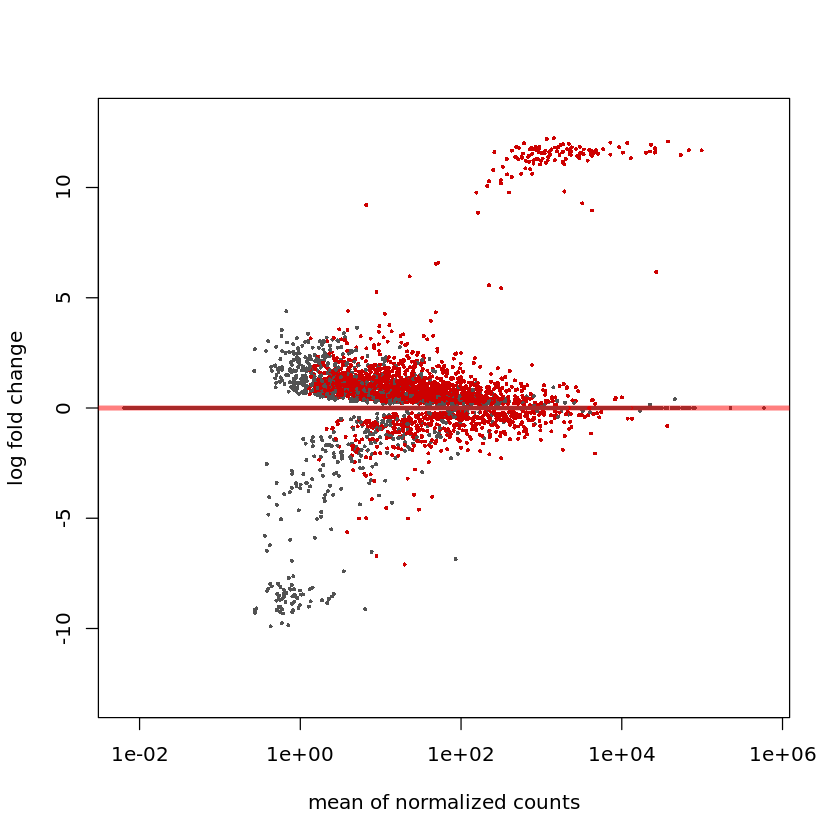

In [88]:
plotMA(resLFC, ylim=c(-13,13))

Here we see the pattern I alluded to earlier, where there is a cloud of extremely overexpressed (>10 LFC) in the infected relative to the control. It is my suspicion that these represent contamination from Loxo rather than an actually response by the crabs. 

Let's see if these match the transcript IDs we pulled out earlier as possible Loxo contaminant transcripts. 

First let's make an ordered data.frame of the significant transcripts.

In [112]:
res_sig <- data.frame(subset(res, padj < 0.05))
res_sig <- res_sig[order(-res_sig$log2FoldChange),]
res_sig

baseMean   log2FoldChange lfcSE     stat     
TRINITY_DN85899_c0_g1_i1   1424.7840 12.26715       0.4445381 27.59526 
TRINITY_DN98899_c0_g1_i1   1162.4834 12.22471       0.3937168 31.04949 
TRINITY_DN19987_c0_g1_i1  37383.9752 12.10107       0.3318683 36.46348 
TRINITY_DN50085_c0_g1_i1   7216.9053 12.06161       0.3963491 30.43177 
TRINITY_DN74741_c0_g1_i1    607.8118 12.03959       0.4835273 24.89951 
TRINITY_DN80409_c0_g1_i1  11692.3408 12.03888       0.3825126 31.47316 
TRINITY_DN60860_c0_g1_i1   2188.9247 12.00837       0.4209431 28.52730 
TRINITY_DN157863_c0_g1_i1  1872.3459 11.99681       0.4331513 27.69657 
TRINITY_DN135642_c0_g1_i1  1755.0800 11.98694       0.5426055 22.09144 
TRINITY_DN50011_c0_g1_i1  23082.6038 11.96841       0.3934662 30.41789 
TRINITY_DN134734_c0_g1_i1   851.8327 11.89518       0.4487790 26.50566 
TRINITY_DN86249_c0_g1_i1   1617.9669 11.87137       0.5074222 23.39545 
TRINITY_DN57851_c0_g1_i1   3003.1226 11.86582       0.3757768 31.57678 
TRINITY_DN91413_c0_g1_i1    941.9773 11.86082       0.3983708 29.77331 
TRINITY_DN60293_c0_g1_i1   1585.5205 11.84327       0.4755173 24.90609 
TRINITY_DN57720_c0_g1_i1   1475.3705 11.84260       0.4305670 27.50467 
TRINITY_DN132183_c0_g1_i1   756.5510 11.83989       0.4143299 28.57601 
TRINITY_DN103032_c0_g1_i1  2380.5890 11.83897       0.3819963 30.99236 
TRINITY_DN80491_c0_g1_i1   9266.9257 11.83830       0.3718812 31.83355 
TRINITY_DN155874_c0_g1_i1   486.0349 11.81813       0.4062479 29.09093 
TRINITY_DN151054_c0_g1_i1   523.5639 11.79958       0.4136321 28.52676 
TRINITY_DN47573_c0_g1_i1  25946.4941 11.79203       0.3408485 34.59611 
TRINITY_DN141230_c0_g1_i1  2270.5299 11.77924       0.4872985 24.17254 
TRINITY_DN82676_c0_g1_i1    780.8767 11.77782       0.4000173 29.44326 
TRINITY_DN120239_c0_g1_i1  2688.1088 11.77408       0.4251674 27.69281 
TRINITY_DN142548_c0_g1_i1  2093.4540 11.77318       0.4510599 26.10114 
TRINITY_DN94855_c0_g1_i1    766.5092 11.76948       0.4100273 28.70413 
TRINITY_DN114680_c0_g1_i1  5862.3102 11.76823       0.4576123 25.71659 
TRINITY_DN103226_c0_g1_i1   717.1787 11.76755       0.4408063 26.69552 
TRINITY_DN74222_c0_g1_i1    922.8027 11.76297       0.4315614 27.25678 
...                       ...        ...            ...       ...      
TRINITY_DN14157_c0_g1_i1   83.89386   -7.879530     1.649771  -4.776134
TRINITY_DN21051_c0_g1_i1   62.58587   -7.891642     1.623241  -4.861658
TRINITY_DN147449_c0_g1_i1  19.08123   -7.906902     2.315797  -3.414333
TRINITY_DN23781_c0_g1_i1   79.38438   -7.956873     2.257945  -3.523944
TRINITY_DN13366_c0_g1_i1   64.25435   -7.973684     2.350005  -3.393049
TRINITY_DN93609_c0_g1_i1   32.58295   -7.977969     2.253314  -3.540549
TRINITY_DN15912_c0_g1_i1   30.95554   -7.996108     2.115147  -3.780403
TRINITY_DN95228_c0_g1_i1   47.03367   -8.039965     2.073350  -3.877766
TRINITY_DN80778_c0_g1_i1   58.54765   -8.051339     1.785184  -4.510090
TRINITY_DN4715_c0_g1_i1   102.65025   -8.082352     1.848850  -4.371556
TRINITY_DN92710_c0_g1_i1   50.24832   -8.104797     1.991429  -4.069840
TRINITY_DN109572_c0_g1_i1 151.26552   -8.158647     1.473410  -5.537257
TRINITY_DN94316_c0_g1_i1   74.93746   -8.164761     2.152372  -3.793378
TRINITY_DN5906_c1_g1_i1    53.95139   -8.208567     2.212298  -3.710425
TRINITY_DN272_c0_g1_i2     26.76452   -8.236143     1.815758  -4.535925
TRINITY_DN14517_c0_g1_i1   42.16978   -8.294827     2.439259  -3.400553
TRINITY_DN1876_c0_g2_i1    14.92489   -8.372680     2.266814  -3.693590
TRINITY_DN129491_c0_g1_i1  19.90878   -8.428341     2.464891  -3.419356
TRINITY_DN17217_c0_g1_i1  575.96279   -8.483669     1.438127  -5.899111
TRINITY_DN3369_c0_g1_i1   331.62025   -8.521172     1.536952  -5.544202
TRINITY_DN99748_c0_g1_i1   21.15845   -8.524719     2.343272  -3.637955
TRINITY_DN3684_c0_g1_i1    36.30526   -8.589969     2.262640  -3.796437
TRINITY_DN8875_c0_g1_i1    47.60278   -8.646215     1.978614  -4.369834
TRINITY_DN9318_c0_g1_i1    69.63697   -8.680717     1.864791  -4.6

You can see that there are some extremely significant, extremely overexpressed transcripts at the top, many of which have high rates of expression overall. These are likely contamination from Loxo. I am going to compare the list of transcripts I made earlier to these to see how much of an overlap there is. 

There are 2377 significant transcripts, 1250 up and 1127 down. There were 5797 transcripts that had higher expression in one of the two parasite samples than any of the clean samples. Let's look at the intersect. 

In [199]:
contam_intersect <- intersect(contam_IDs, rownames(res_sig))
length(contam_intersect)

[1] 448

Okay so there are 448 transcripts that came up as significant that were also identified as potential contamination. Let's take a look at the significant results table with those removed:

In [204]:
tail(res_sig[!(rownames(res_sig) %in% contam_intersect),],n=20)

baseMean  log2FoldChange lfcSE    stat     
TRINITY_DN92710_c0_g1_i1   50.24832  -8.104797     1.991429 -4.069840
TRINITY_DN109572_c0_g1_i1 151.26552  -8.158647     1.473410 -5.537257
TRINITY_DN94316_c0_g1_i1   74.93746  -8.164761     2.152372 -3.793378
TRINITY_DN5906_c1_g1_i1    53.95139  -8.208567     2.212298 -3.710425
TRINITY_DN272_c0_g1_i2     26.76452  -8.236143     1.815758 -4.535925
TRINITY_DN14517_c0_g1_i1   42.16978  -8.294827     2.439259 -3.400553
TRINITY_DN1876_c0_g2_i1    14.92489  -8.372680     2.266814 -3.693590
TRINITY_DN129491_c0_g1_i1  19.90878  -8.428341     2.464891 -3.419356
TRINITY_DN17217_c0_g1_i1  575.96279  -8.483669     1.438127 -5.899111
TRINITY_DN3369_c0_g1_i1   331.62025  -8.521172     1.536952 -5.544202
TRINITY_DN99748_c0_g1_i1   21.15845  -8.524719     2.343272 -3.637955
TRINITY_DN3684_c0_g1_i1    36.30526  -8.589969     2.262640 -3.796437
TRINITY_DN8875_c0_g1_i1    47.60278  -8.646215     1.978614 -4.369834
TRINITY_DN9318_c0_g1_i1    69.63697  -8.680717     1.864791 -4.655062
TRINITY_DN6327_c0_g1_i2   234.95478  -8.776971     1.818974 -4.825231
TRINITY_DN93264_c0_g1_i1   12.45550  -9.272850     2.388006 -3.883093
TRINITY_DN2414_c0_g1_i1    20.18046 -10.134620     2.990890 -3.388496
TRINITY_DN12675_c0_g1_i1   12.10526 -23.783258     2.991012 -7.951576
TRINITY_DN111888_c0_g1_i1  15.07193 -24.081371     2.990952 -8.051407
TRINITY_DN113336_c0_g1_i1  19.26839 -24.174535     2.990899 -8.082699
                          pvalue       padj        
TRINITY_DN92710_c0_g1_i1  4.704537e-05 4.858654e-03
TRINITY_DN109572_c0_g1_i1 3.072457e-08 9.083802e-06
TRINITY_DN94316_c0_g1_i1  1.486117e-04 1.148292e-02
TRINITY_DN5906_c1_g1_i1   2.069114e-04 1.473563e-02
TRINITY_DN272_c0_g1_i2    5.735151e-06 8.954640e-04
TRINITY_DN14517_c0_g1_i1  6.724976e-04 3.455734e-02
TRINITY_DN1876_c0_g2_i1   2.211103e-04 1.553778e-02
TRINITY_DN129491_c0_g1_i1 6.276955e-04 3.283053e-02
TRINITY_DN17217_c0_g1_i1  3.654650e-09 1.321031e-06
TRINITY_DN3369_c0_g1_i1   2.952975e-08 8.804536e-06
TRINITY_DN99748_c0_g1_i1  2.748119e-04 1.823120e-02
TRINITY_DN3684_c0_g1_i1   1.467908e-04 1.137553e-02
TRINITY_DN8875_c0_g1_i1   1.243410e-05 1.693412e-03
TRINITY_DN9318_c0_g1_i1   3.238827e-06 5.613329e-04
TRINITY_DN6327_c0_g1_i2   1.398413e-06 2.721093e-04
TRINITY_DN93264_c0_g1_i1  1.031361e-04 8.653265e-03
TRINITY_DN2414_c0_g1_i1   7.027702e-04 3.564440e-02
TRINITY_DN12675_c0_g1_i1  1.841534e-15 1.079835e-12
TRINITY_DN111888_c0_g1_i1 8.184782e-16 4.880720e-13
TRINITY_DN113336_c0_g1_i1 6.334868e-16 3.799049e-13

A lot of those transcripts are now removed. There are just around 7 or 8 of them left, depending on where you draw the line.

I am going to repeat the lfc shrinking and visualization with the contam transcrips removed. I am subsetting the dds object within the `lfcShrink()` function, using `subset()` to keep only transcripts that do not appear in the conta_IDs list. 

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895


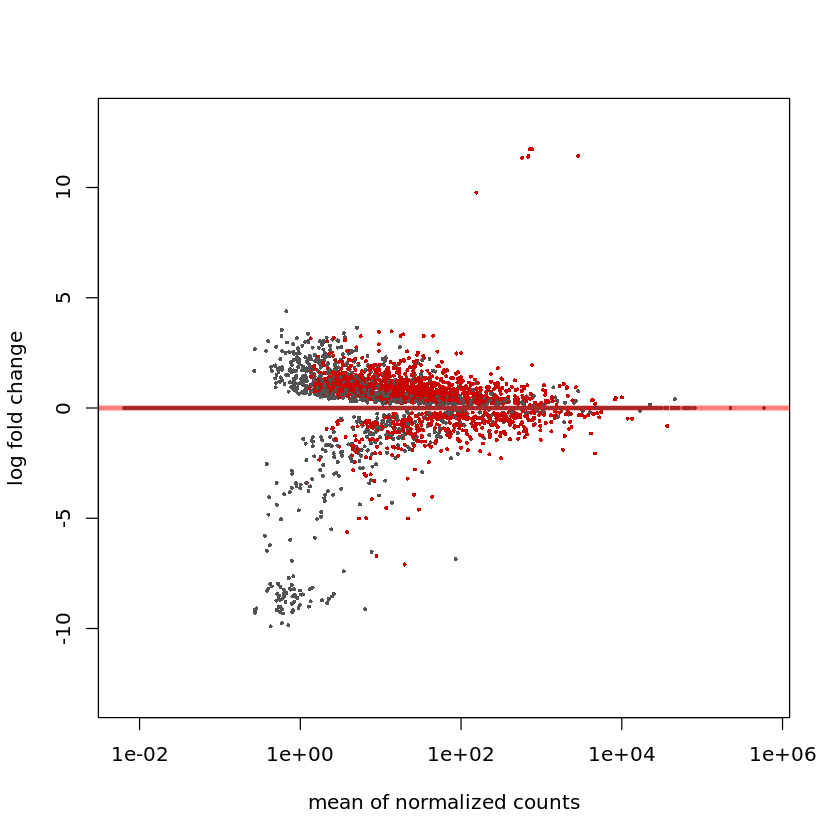

In [213]:
resLFC_nocontam <- lfcShrink(subset(dds, !rownames(dds) %in% contam_IDs), coef="condition_P_vs_C", type="apeglm")
plotMA(resLFC_nocontam, ylim=c(-13,13))

You can see now that the big cloud of points at the top right has mostly disappeared. A few points remain. I am still going to consider these as contamination and remove them. I am going to do this by considering transcripts that are overexpressed above the absolute value of the most underexpressed transcript. This is done using the shrunk LFCs.

In [225]:
resLFC_nocontam_sig <- data.frame(subset(resLFC_nocontam, padj < 0.05))
resLFC_nocontam_sig <- resLFC_nocontam_sig[order(-resLFC_nocontam_sig$log2FoldChange),]
head(resLFC_nocontam_sig,n=20)

baseMean    log2FoldChange lfcSE     pvalue       
TRINITY_DN94855_c0_g1_i1   766.509208 11.740458      0.4123791 3.388060e-181
TRINITY_DN103226_c0_g1_i1  717.178725 11.729469      0.4432693 5.305766e-157
TRINITY_DN128205_c0_g1_i1 2871.442818 11.439449      0.4197738 1.292932e-164
TRINITY_DN115787_c0_g1_i1  691.115560 11.423670      0.4458718 1.195002e-147
TRINITY_DN121942_c0_g1_i1  684.441598 11.391444      0.4159474 3.020168e-168
TRINITY_DN122219_c0_g1_i1  576.969262 11.348327      0.4548932 1.988178e-140
TRINITY_DN128046_c0_g1_i1  155.048578  9.770940      0.4161875 1.112043e-125
TRINITY_DN56560_c0_g1_i1    13.689345  3.471850      0.4844604  5.523101e-14
TRINITY_DN82187_c0_g1_i1     9.513082  3.454312      0.6562764  9.251920e-09
TRINITY_DN61940_c0_g1_i1    19.073210  3.335402      0.4591079  2.658790e-14
TRINITY_DN35566_c0_g1_i1    45.143537  3.272066      0.4481272  2.107298e-14
TRINITY_DN51295_c0_g1_i1    17.674442  3.263155      0.6244357  1.101308e-08
TRINITY_DN79806_c0_g1_i1    34.246108  3.259549      0.4776683  6.484970e-13
TRINITY_DN146992_c0_g1_i1    5.624471  3.252657      0.7942949  2.348784e-06
TRINITY_DN89969_c0_g1_i1     2.618407  3.182304      0.8593963  4.174807e-04
TRINITY_DN26629_c0_g1_i1     1.343547  3.152347      0.5829288  3.544042e-04
TRINITY_DN149883_c0_g1_i1    3.592164  3.064751      0.8258970  1.074007e-05
TRINITY_DN135972_c0_g1_i1    2.149302  3.027378      0.7544622  3.074491e-06
TRINITY_DN72504_c0_g1_i1     4.998506  2.751586      0.7425460  1.032222e-05
TRINITY_DN158045_c0_g1_i1    3.841803  2.581041      0.5094681  2.287068e-08
                          padj         
TRINITY_DN94855_c0_g1_i1  3.436780e-176
TRINITY_DN103226_c0_g1_i1 1.345516e-152
TRINITY_DN128205_c0_g1_i1 4.371747e-160
TRINITY_DN115787_c0_g1_i1 2.424372e-143
TRINITY_DN121942_c0_g1_i1 1.531799e-163
TRINITY_DN122219_c0_g1_i1 3.361280e-136
TRINITY_DN128046_c0_g1_i1 1.611477e-121
TRINITY_DN56560_c0_g1_i1   2.948696e-10
TRINITY_DN82187_c0_g1_i1   9.675219e-06
TRINITY_DN61940_c0_g1_i1   1.798015e-10
TRINITY_DN35566_c0_g1_i1   1.526858e-10
TRINITY_DN51295_c0_g1_i1   1.095240e-05
TRINITY_DN79806_c0_g1_i1   2.656396e-09
TRINITY_DN146992_c0_g1_i1  7.447744e-04
TRINITY_DN89969_c0_g1_i1   3.005565e-02
TRINITY_DN26629_c0_g1_i1   2.709122e-02
TRINITY_DN149883_c0_g1_i1  2.373531e-03
TRINITY_DN135972_c0_g1_i1  9.281853e-04
TRINITY_DN72504_c0_g1_i1   2.296197e-03
TRINITY_DN158045_c0_g1_i1  1.999962e-05

Okay there's the table. Now find rownames of rows with higher LFC values than absolute value of lowest LFC value. 

In [226]:
contam_add <- rownames(resLFC_nocontam_sig[resLFC_nocontam_sig$log2FoldChange > abs(min(resLFC_nocontam_sig$log2FoldChange)),])
contam_add

[1] "TRINITY_DN94855_c0_g1_i1"  "TRINITY_DN103226_c0_g1_i1"
[3] "TRINITY_DN128205_c0_g1_i1" "TRINITY_DN115787_c0_g1_i1"
[5] "TRINITY_DN121942_c0_g1_i1" "TRINITY_DN122219_c0_g1_i1"
[7] "TRINITY_DN128046_c0_g1_i1"

Okay here the seven remaining contigs that we will consider contamination. I am going to add them to the list of contam_IDs, which will be used for removal from the intial counts object. Then the analysis will be re-run. This is to account for renormalization after removal, since many of these contigs had high mean expression across samples. 

In [227]:
contam_IDs <- c(contam_IDs, contam_add)
length(contam_IDs)

[1] 5804

Okay successfully added. 

Now to check out a multi-factor design, analyzing both range and condition. 

In [82]:
vsd <- vst(dds)

In [85]:
library("RColorBrewer")
library("pheatmap")
sampleDists <- dist(t(assay(vsd)))
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(vsd$condition, vsd$range, sep="-")
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors)

ERROR: Error in library("pheatmap"): there is no package called ‘pheatmap’


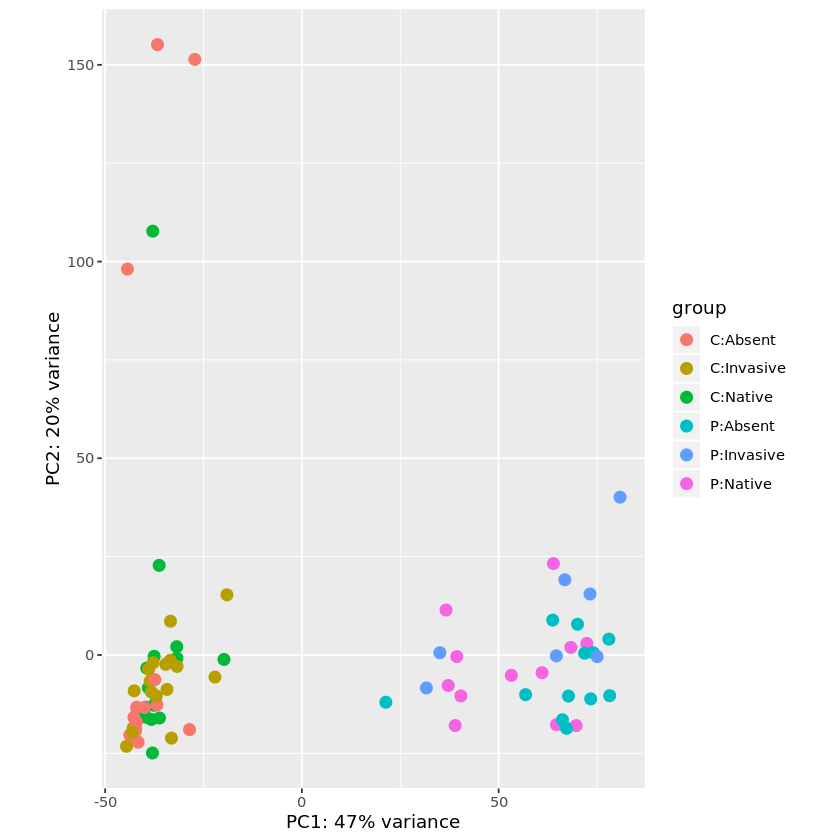

In [83]:
plotPCA(vsd, intgroup=c("condition", "range"))

In [65]:
ddsMF <- dds

Let's remove the Fort Pierce (FP) samples because the invasive status of Loxo is unresolved there. FP are in rows 11-22. 

In [66]:
ddsMF_noFP <- ddsMF[,-c(11:22)]
ddsMF_noFP

class: DESeqDataSet 
dim: 149511 69 
metadata(1): version
assays(6): counts mu ... replaceCounts replaceCooks
rownames(149511): TRINITY_DN2522_c0_g1_i3 TRINITY_DN68400_c0_g1_i1 ...
  TRINITY_DN131036_c0_g1_i1 TRINITY_DN46128_c0_g1_i1
rowData names(23): baseMean baseVar ... maxCooks replace
colnames(69): AP_C_1 AP_C_2 ... SC_P_2 SC_P_3
colData names(6): site condition ... sizeFactor replaceable

Now you can see that we only have 69 samples, after removing the 12 from FP. 

In [73]:
ddsMF_noFP$group <- factor(paste0(ddsMF_noFP$range, ddsMF_noFP$condition)) 
ddsMF_noFP$group

[1] NativeC   NativeC   NativeC   NativeC   NativeC   NativeC   NativeP  
 [8] NativeP   NativeP   NativeP   NativeC   NativeC   NativeC   NativeC  
[15] NativeC   NativeC   NativeP   NativeP   AbsentC   AbsentC   AbsentC  
[22] InvasiveC InvasiveC InvasiveP InvasiveC InvasiveC InvasiveC InvasiveP
[29] InvasiveC InvasiveC InvasiveC InvasiveC InvasiveC InvasiveC InvasiveP
[36] InvasiveP AbsentC   AbsentC   AbsentC   AbsentC   AbsentC   AbsentC  
[43] AbsentP   AbsentP   AbsentP   AbsentP   AbsentP   AbsentP   AbsentC  
[50] AbsentC   AbsentC   AbsentC   AbsentC   AbsentC   AbsentP   AbsentP  
[57] AbsentP   AbsentP   AbsentP   AbsentP   InvasiveC InvasiveC InvasiveC
[64] InvasiveC InvasiveC InvasiveC InvasiveP InvasiveP InvasiveP
Levels: AbsentC AbsentP InvasiveC InvasiveP NativeC NativeP

In [74]:
design(ddsMF_noFP) <- ~ group
ddsMF_noFP <- DESeq(ddsMF_noFP)

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 12266 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [77]:
resMF_noFP <- results(ddsMF_noFP, alpha=0.05)
resMF_noFP
summary(resMF_noFP)

log2 fold change (MLE): group NativeP vs AbsentC 
Wald test p-value: group NativeP vs AbsentC 
DataFrame with 149511 rows and 6 columns
                                    baseMean     log2FoldChange
                                   <numeric>          <numeric>
TRINITY_DN2522_c0_g1_i3     6130.46736837643  0.197986920677313
TRINITY_DN68400_c0_g1_i1      28.99232254402   1.49194324768313
TRINITY_DN140775_c0_g1_i1   1.04073114649582  0.205046811298963
TRINITY_DN75566_c0_g1_i1    67.4701849518878 -0.193809975013515
TRINITY_DN88538_c0_g1_i1  0.0731384114313201 -0.802580660941875
...                                      ...                ...
TRINITY_DN24218_c0_g1_i1    61.1680868224187  0.246470004796439
TRINITY_DN144968_c0_g1_i1   1.15798708783082   1.05979257963071
TRINITY_DN8739_c0_g1_i1     855.379171048832   0.15285016051543
TRINITY_DN131036_c0_g1_i1   55.8425836148422  0.342836223117198
TRINITY_DN46128_c0_g1_i1    7.96024834561026 -0.918292432810512
                                


out of 148998 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 5114, 3.4%
LFC < 0 (down)     : 6340, 4.3%
outliers [1]       : 289, 0.19%
low counts [2]     : 29331, 20%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [80]:
resultsNames(ddsMF_noFP)

[1] "Intercept"                  "group_AbsentP_vs_AbsentC"  
[3] "group_InvasiveC_vs_AbsentC" "group_InvasiveP_vs_AbsentC"
[5] "group_NativeC_vs_AbsentC"   "group_NativeP_vs_AbsentC"